In [1]:
import os
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# read data from ./CrackDataset_DL_HY/SematicSeg_Dataset
DATASET_PATH = os.path.join(os.getcwd(), 'SematicSeg_Dataset')
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, 'Original Image')
MASK_DATASET_PATH = os.path.join(DATASET_PATH, 'Labels')
    
# define the test split
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 2
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-2#INIT_LR = 1e-6
NUM_EPOCHS = 1
BATCH_SIZE = 2
# define the input image dimensions
INPUT_IMAGE_WIDTH = 480
INPUT_IMAGE_HEIGHT = 320

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = os.path.join(os.getcwd(), 'output')

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_IMAGE_PATHS = os.path.sep.join([BASE_OUTPUT, "test_image_paths.txt"])
TEST_MASK_PATHS = os.path.sep.join([BASE_OUTPUT, "test_mask_paths.txt"])

In [3]:
class SegmentationDataSet(Dataset):
    def __init__(self,rootdir,labeldir,img_name_ls, label_name_ls,transform=None):
        assert len(img_name_ls)==len(label_name_ls)
        self.data_dir=rootdir
        self.label_dir=labeldir
        self.img_name_ls = img_name_ls
        self.label_name_ls = label_name_ls
        self.data_len = len(img_name_ls)
        self.transform = transform
    
    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        img_name = self.img_name_ls[index]
        label_name = self.label_name_ls[index]
        img_path = os.path.join(self.data_dir, img_name)
        label_path = os.path.join(self.label_dir, label_name)
        img = cv2.imread(img_path)
        label = cv2.imread(label_path)
        # resize the image and mask
        img = cv2.resize(img, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
        label = cv2.resize(label, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
        # convert mask to 0 and 1
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        label[label > 0] = 1
        label = label.astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            img = self.transform(img)
            label = self.transform(label)
        return img, label
        

In [4]:
class Conv(nn.Module):
    def __init__(self, C_in, C_out):
        super(Conv, self).__init__()
        self.layer = nn.Sequential(

            nn.Conv2d(C_in, C_out, 3, 1, 1),
            nn.BatchNorm2d(C_out),
            nn.Dropout(0.3),
            nn.LeakyReLU(),

            nn.Conv2d(C_out, C_out, 3, 1, 1),
            nn.BatchNorm2d(C_out),
            nn.Dropout(0.4),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.layer(x)


class DownSampling(nn.Module):
    def __init__(self, C):
        super(DownSampling, self).__init__()
        self.Down = nn.Sequential(
            nn.Conv2d(C, C, 3, 2, 1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.Down(x)


class UpSampling(nn.Module):

    def __init__(self, C):
        super(UpSampling, self).__init__()
        self.Up = nn.Conv2d(C, C // 2, 1, 1)

    def forward(self, x, r):
        up = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.Up(up)
        return torch.cat((x, r), 1)


class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()

        self.C1 = Conv(3, 64)
        self.D1 = DownSampling(64)
        self.C2 = Conv(64, 128)
        self.D2 = DownSampling(128)
        self.C3 = Conv(128, 256)
        self.D3 = DownSampling(256)
        self.C4 = Conv(256, 512)
        self.D4 = DownSampling(512)
        self.C5 = Conv(512, 1024)

        self.U1 = UpSampling(1024)
        self.C6 = Conv(1024, 512)
        self.U2 = UpSampling(512)
        self.C7 = Conv(512, 256)
        self.U3 = UpSampling(256)
        self.C8 = Conv(256, 128)
        self.U4 = UpSampling(128)
        self.C9 = Conv(128, 64)

        self.pred = torch.nn.Conv2d(64, 1, 3, 1, 1)

    def forward(self, x):
        R1 = self.C1(x)
        R2 = self.C2(self.D1(R1))
        R3 = self.C3(self.D2(R2))
        R4 = self.C4(self.D3(R3))
        Y1 = self.C5(self.D4(R4))

        O1 = self.C6(self.U1(Y1, R4))
        O2 = self.C7(self.U2(O1, R3))
        O3 = self.C8(self.U3(O2, R2))
        O4 = self.C9(self.U4(O3, R1))

        return self.pred(O4)

In [5]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(os.listdir(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(os.listdir(MASK_DATASET_PATH)))

for file_name in imagePaths:
    os.rename(os.path.join(IMAGE_DATASET_PATH,file_name),os.path.join(IMAGE_DATASET_PATH,file_name.lower()))
    
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)

# unpack the training and testing image and mask paths
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_IMAGE_PATHS, "w")
f.write("\n".join(testImages))
f.close()
f = open(TEST_MASK_PATHS, "w")
f.write("\n".join(testMasks))
f.close()

[INFO] saving testing image paths...


In [6]:
#define transformation 
transform = transforms.Compose([
    transforms.ToTensor(),])

#create the train and teste dataset
trainDS = SegmentationDataSet(IMAGE_DATASET_PATH, MASK_DATASET_PATH, trainImages, trainMasks, transform = transform)
testDS = SegmentationDataSet(IMAGE_DATASET_PATH, MASK_DATASET_PATH, testImages, testMasks, transform = transform)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

#create the train and test dataloaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY)

# get the first batch of training data
images, masks = next(iter(trainLoader))
print(f"[INFO] images shape: {images.shape}")
print(f"[INFO] masks shape: {masks.shape}")

[INFO] found 399 examples in the training set...
[INFO] found 71 examples in the test set...
[INFO] images shape: torch.Size([2, 3, 320, 480])
[INFO] masks shape: torch.Size([2, 1, 320, 480])


In [7]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# dice loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1 - dice

In [8]:
class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,)*2)


    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / union
        mIoU = np.nanmean(IoU)
        return mIoU

    def genConfusionMatrix(self, imgPredict, imgLabel):
        # remove classes from unlabeled pixels in gt image and predict
        imgPredict = torch.sigmoid(imgPredict)
        imgPredict = torch.where(imgPredict>=0.5,1,0)
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix

    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict.cpu(), imgLabel.cpu())

    def recall(self):
        # return all class recall
        # recall = TP / (TP + FN)
        recall = np.diag(self.confusionMatrix) / np.sum(self.confusionMatrix, axis=1)
        return recall

    def precision(self):
        # return all class precision
        # precision = TP / (TP + FP)
        precision = np.diag(self.confusionMatrix) / np.sum(self.confusionMatrix, axis=0)
        return precision

    def F1score(self):
        # return all class F1 score
        # F1 score = 2 * (precision * recall) / (precision + recall)
        precision = self.precision()
        recall = self.recall()
        F1score = 2 * (precision * recall) / (precision + recall)
        return F1score

[INFO] training the network...


200it [00:43,  4.57it/s]:00<?, ?it/s]


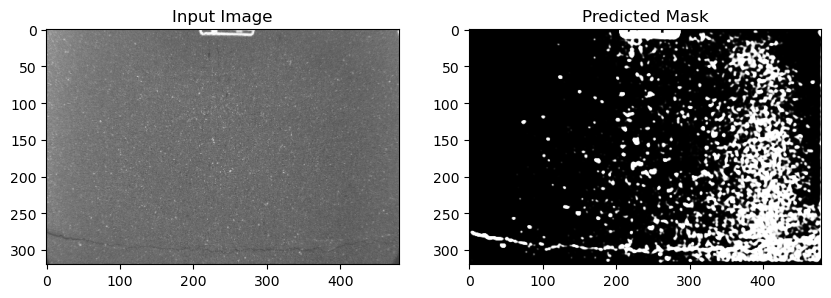

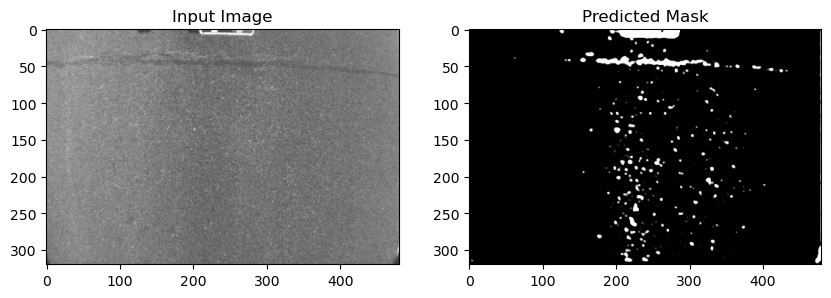

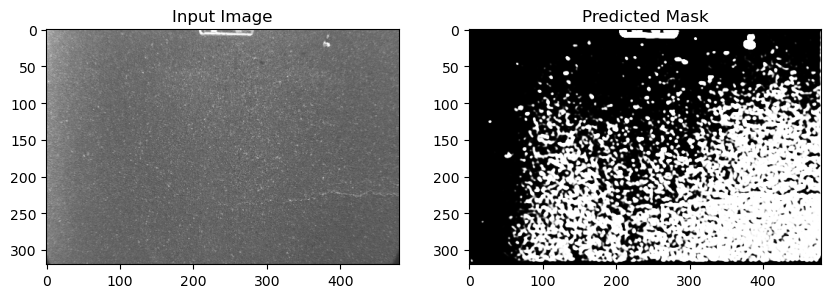

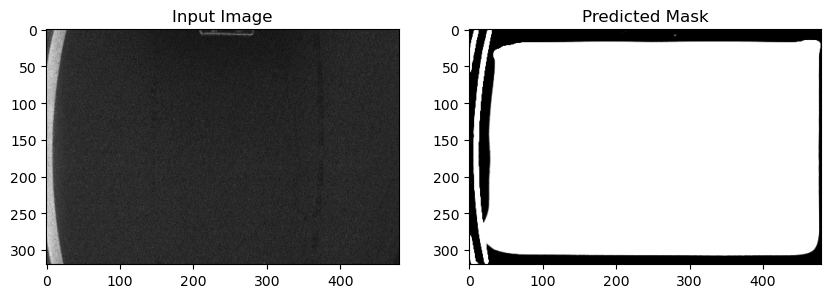

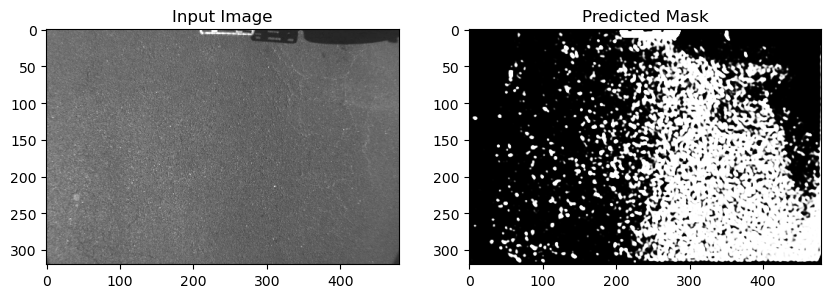

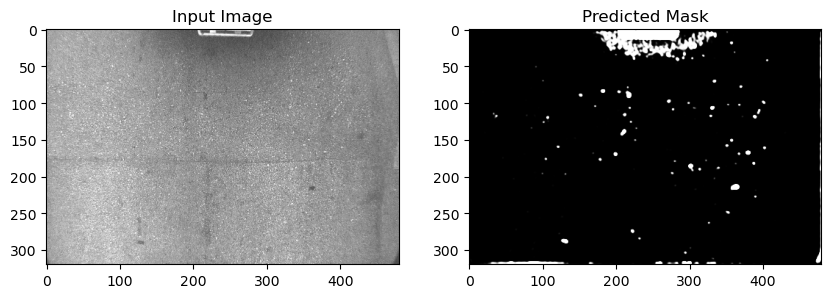

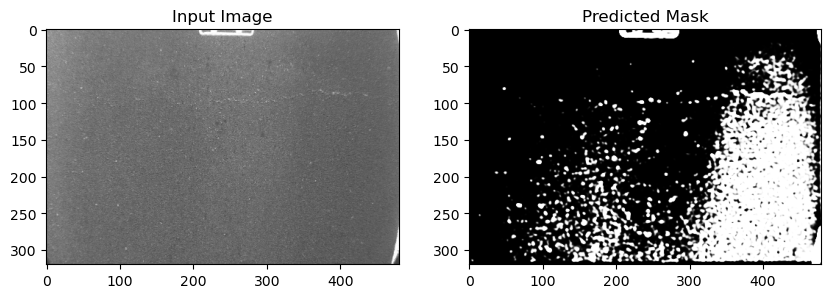

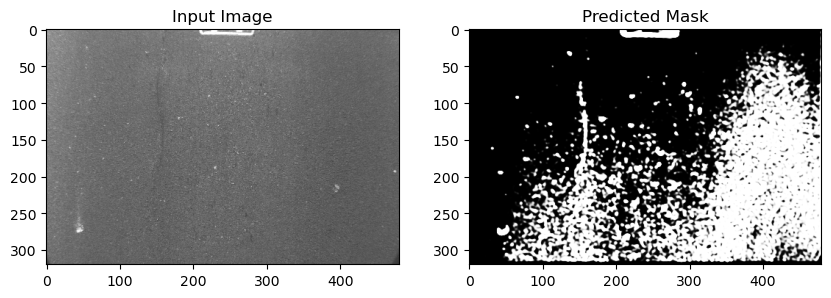

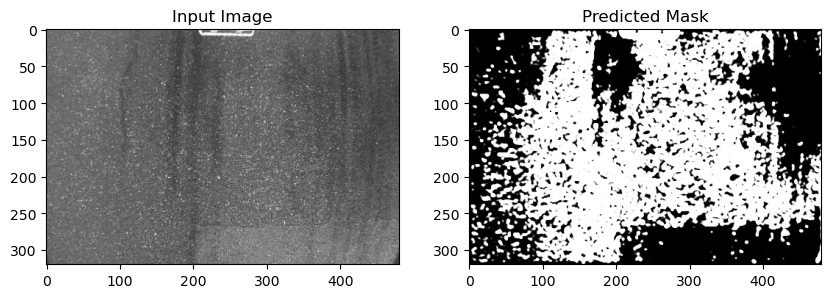

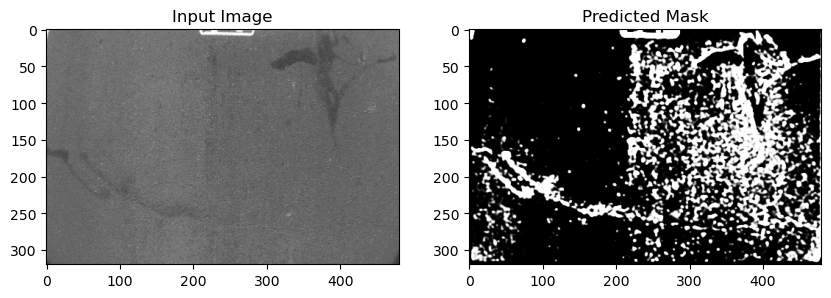

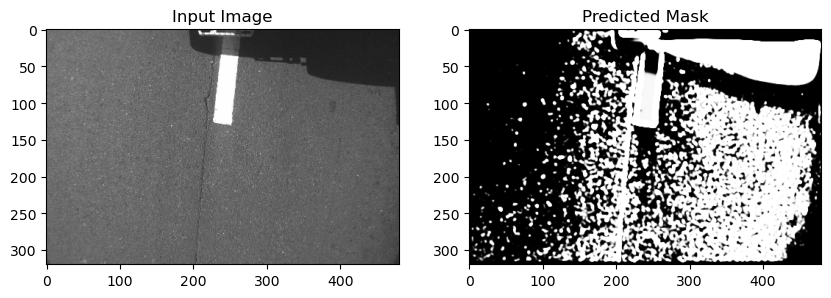

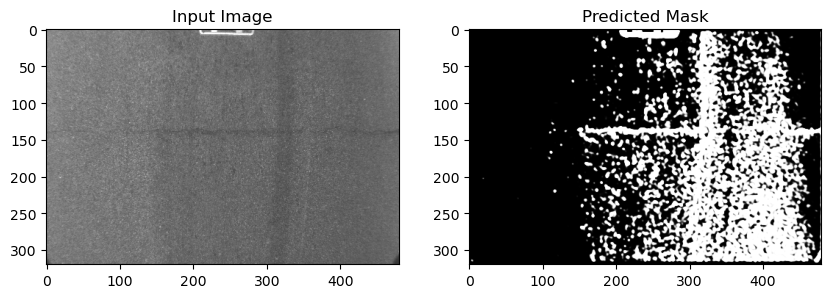

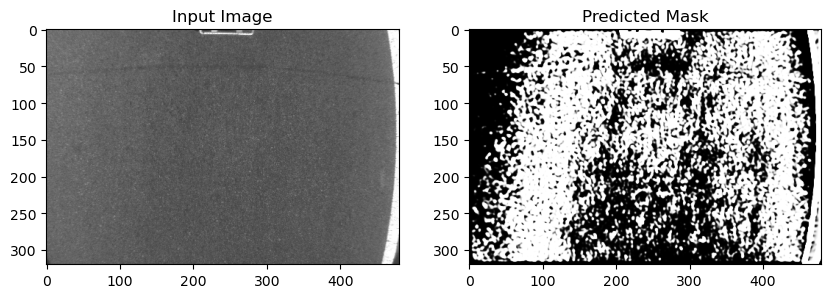

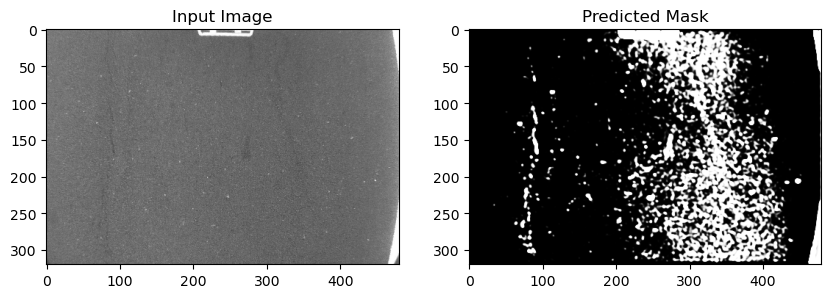

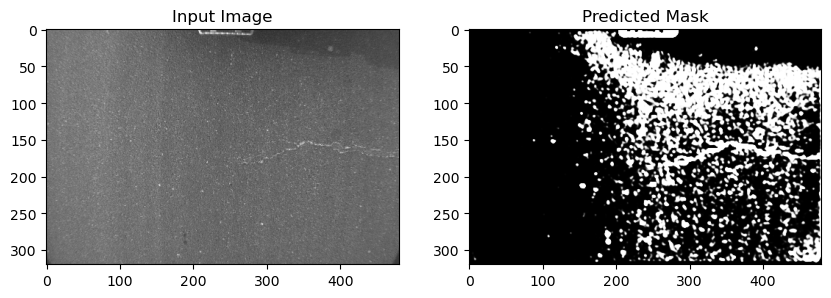

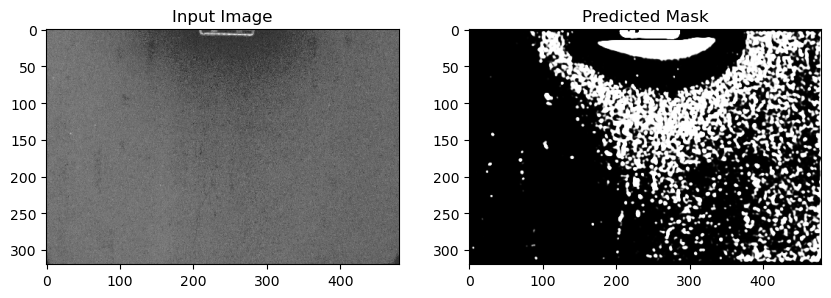

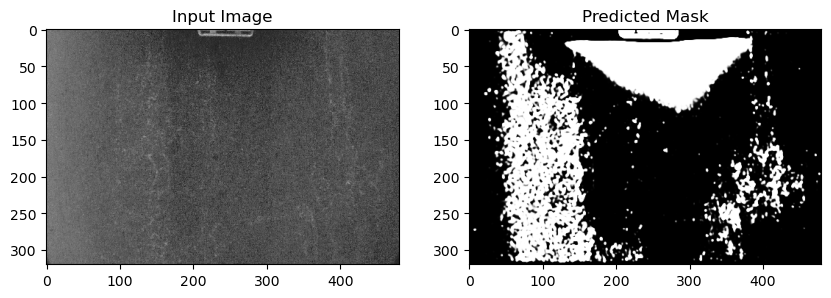

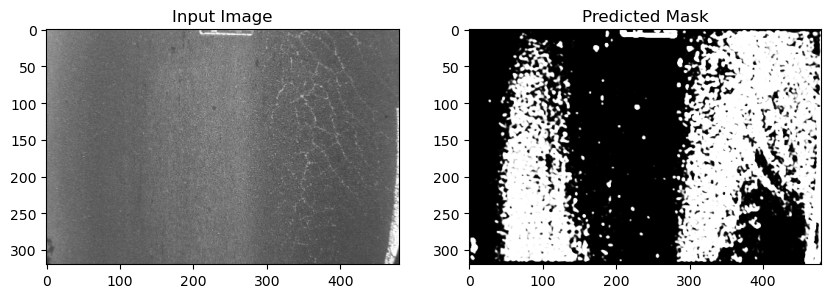

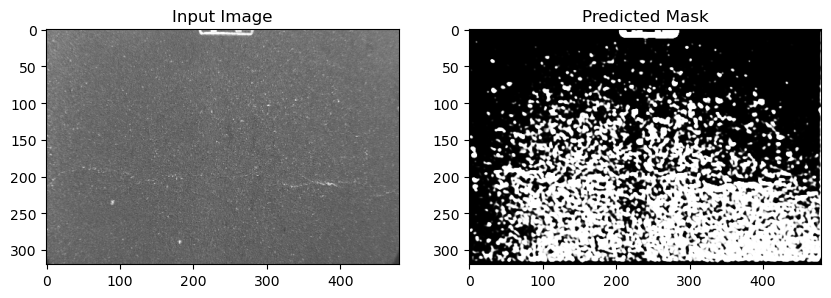

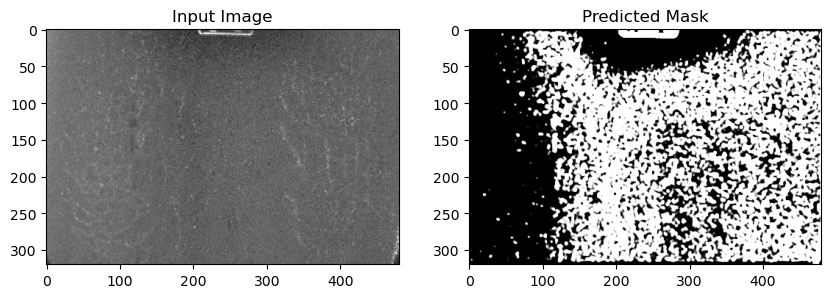

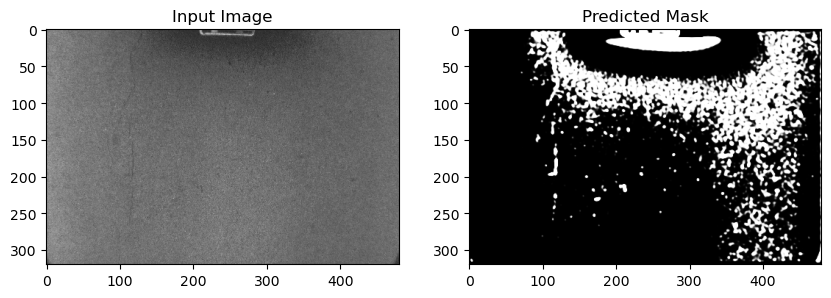

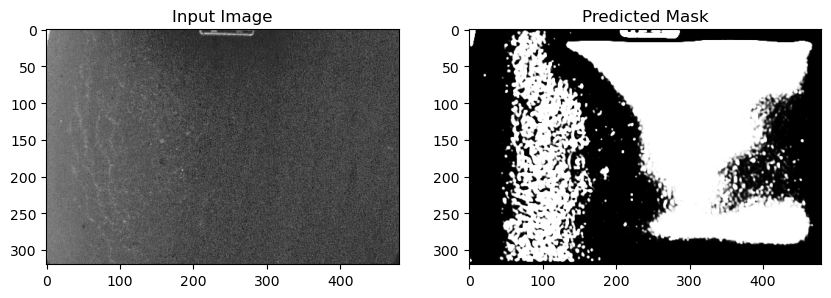

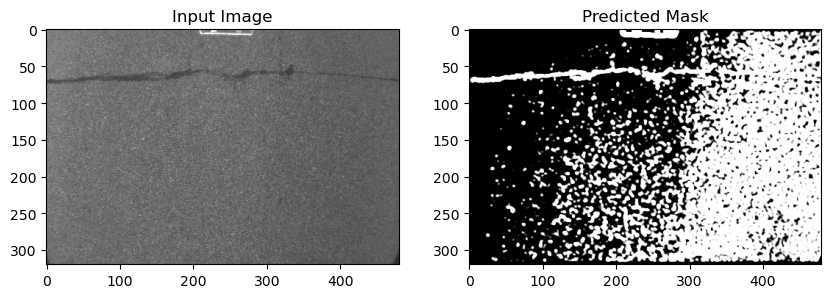

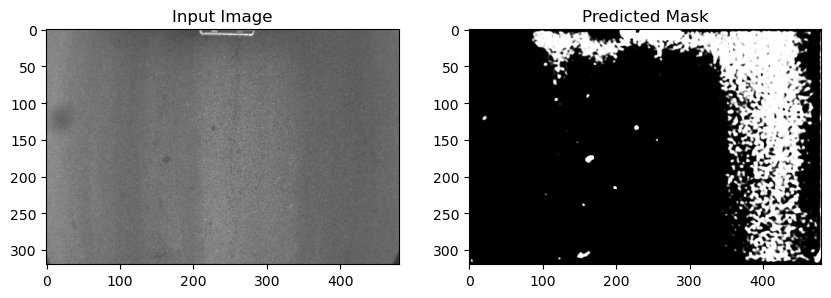

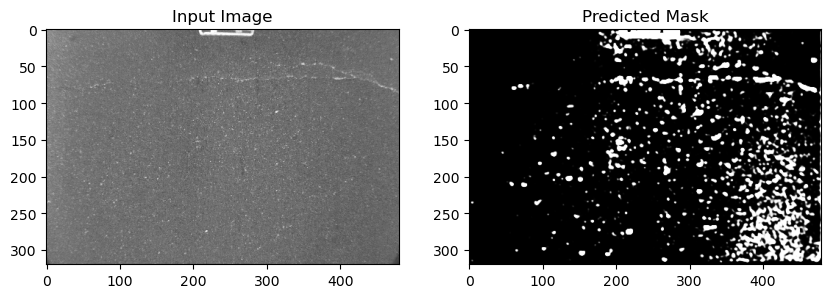

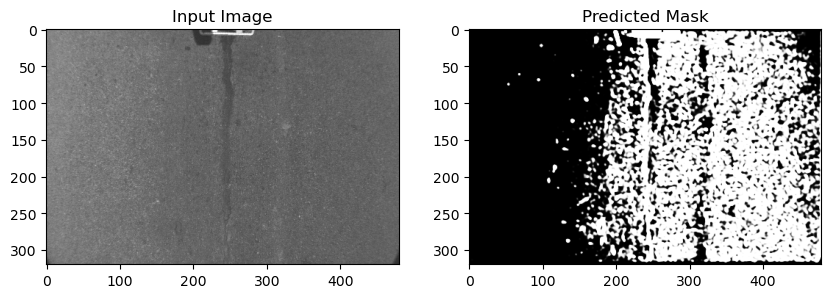

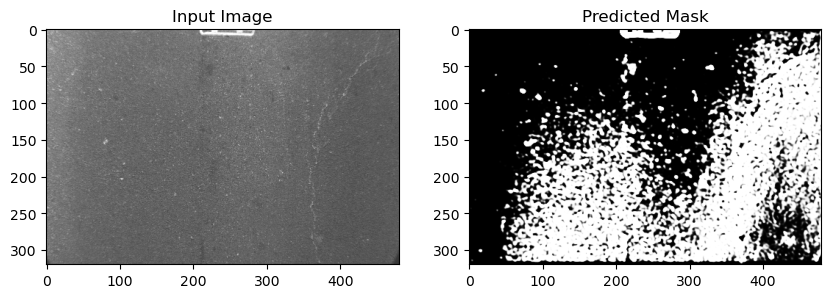

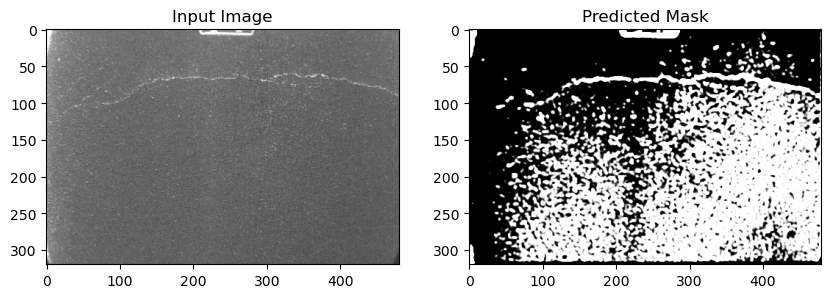

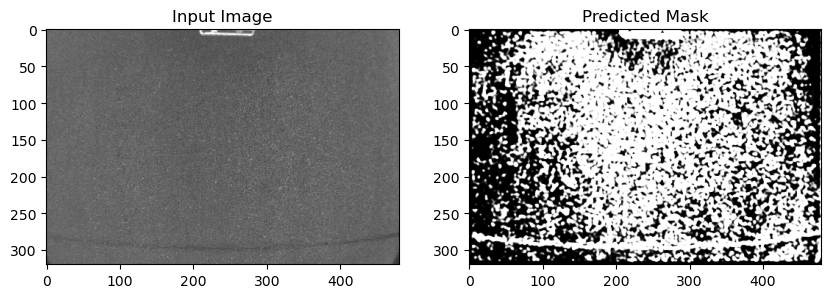

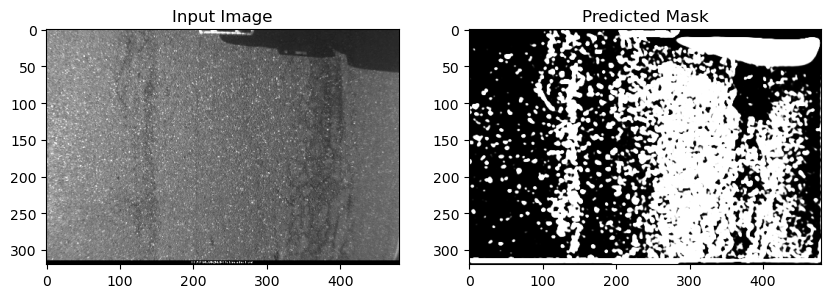

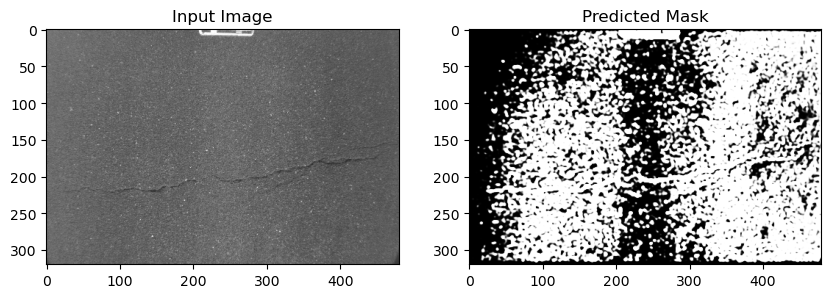

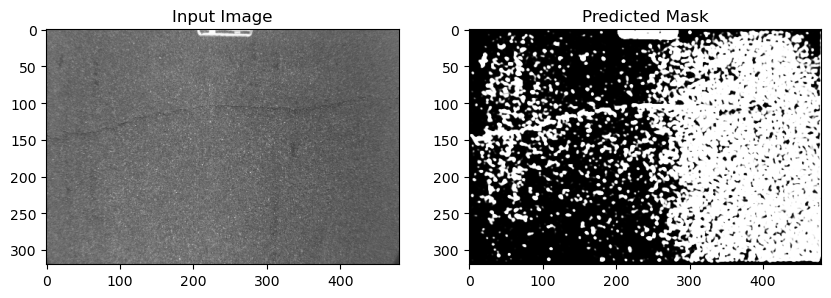

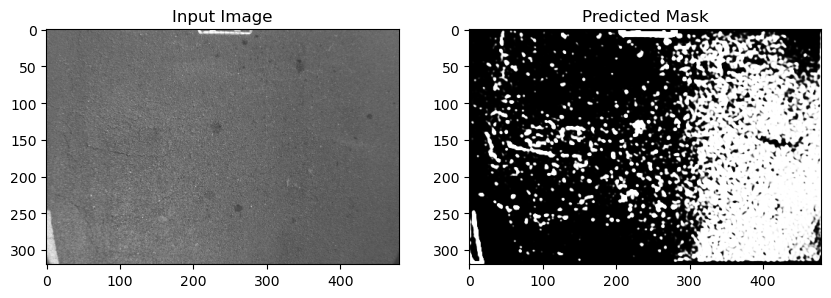

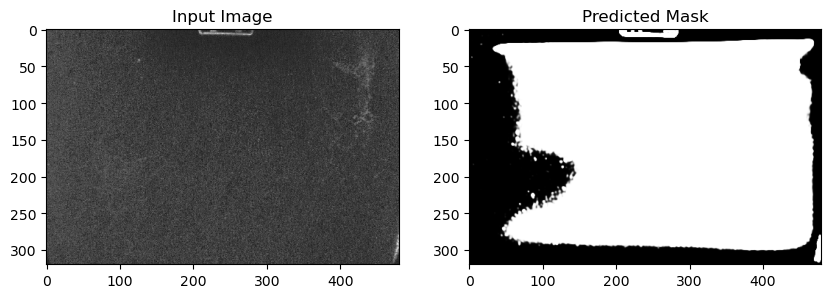

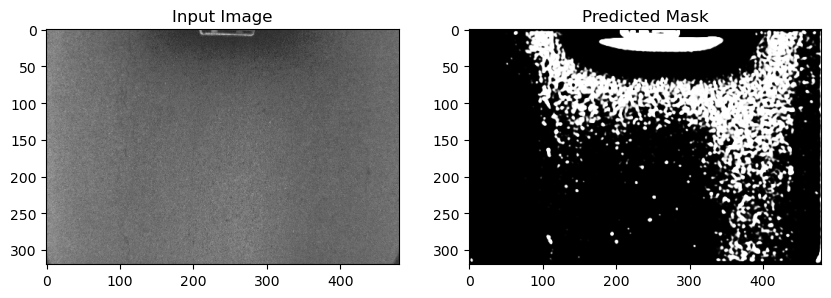

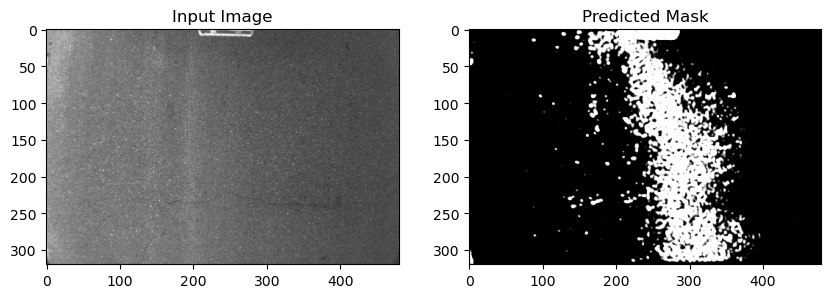

100%|██████████| 1/1 [00:53<00:00, 53.55s/it]

[INFO] EPOCH: 1/1
Train loss: 0.936939, Test loss: 0.9841,mIOU:0.31,precision:0.02,recall:0.47,F1score:0.04

[INFO] total time taken to train the model: 53.55s


In [9]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = DiceLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
milestones = np.array([10, 20, 30, 40])
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.8, last_epoch=- 1, verbose=False)
'''torch.optim.lr_scheduler.MultiStepLR(
                opt, milestones=milestones, gamma=0.1)'''

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
#for e in tqdm(range(NUM_EPOCHS)):

for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	mIOU = 0
	metric = SegmentationMetric(2)
	# loop over the training set
	for (i, (x, y)) in tqdm(enumerate(trainLoader)):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		if(i==0):
			#plot the first image in the batch
			'''fig, ax = plt.subplots(1, 2, figsize=(10, 5))
			ax[0].imshow(x[0].cpu().permute(1, 2, 0))
			ax[0].set_title("Input Image")
			ax[1].imshow(y[0].cpu().squeeze(), cmap="gray")
			ax[1].set_title("Ground Truth Mask")
			plt.show()'''

		pred = unet(x)
		'''print(torch.max(torch.sigmoid(pred)))
		print(torch.min(torch.sigmoid(pred)))'''
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			# plot the prediction and ground truth mask
			if(e%100==0):
				fig, ax = plt.subplots(1, 2, figsize=(10, 5))
				ax[0].imshow(x[0].cpu().permute(1, 2, 0))
				ax[0].set_title("Input Image")
				#ax[1].imshow(pred[0].cpu().squeeze(), cmap="gray")
				ax[1].imshow(torch.sigmoid(pred[0]).cpu().squeeze(), cmap="gray", vmin=0, vmax=1)
				ax[1].set_title("Predicted Mask")
				plt.show()
			totalTestLoss += lossFunc(pred, y)
			#evalution metric
			metric.addBatch(pred, y)
	lr_scheduler.step()
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	avgmIOU = metric.meanIntersectionOverUnion()
	precison = metric.precision()[1]
	recall = metric.recall()[1]
	F1score = metric.F1score()[1]
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f},mIOU:{:.2f},precision:{:.2f},recall:{:.2f},F1score:{:.2f}".format(
		avgTrainLoss, avgTestLoss,avgmIOU,precison,recall,F1score))
	print()
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

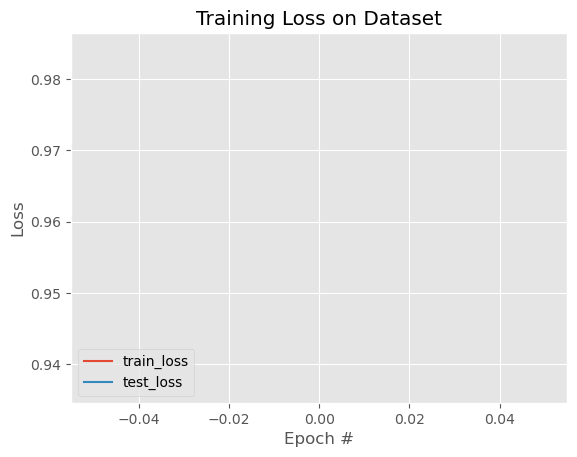

In [10]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)